In [1]:
import sys
sys.path.insert(0, '/home/tim/Classes/CS535/PlanarGrasping/')
# sys.path.insert(0, '/home/tim/Classes/CS535/PlanarGrasping/network/')

import pickle
import matplotlib.pyplot as plt

from network.model import net, data_loader
from network import utils
import numpy as np

from IPython import display
%matplotlib inline

import torch

import torch.optim as optim

In [2]:
json_path = '/home/tim/Classes/CS535/PlanarGrasping/network/experiments/sdf_cnn/params.json'
params = utils.Params(json_path)
params.cuda = torch.cuda.is_available()

data_dir = '/home/tim/Classes/CS535/PlanarGrasping/network/data'

# fetch dataloaders
dataloaders = data_loader.fetch_dataloader(
    ['train', 'val'],data_dir, params)
train_dl = dataloaders['train']
val_dl = dataloaders['val']

# Define the model and optimizer
model = net.Net(params).cuda()
optimizer = optim.Adam(model.parameters(), lr=params.learning_rate)

model.eval()

# reload weights from restore_file if specified
weight_file = '/home/tim/Classes/CS535/PlanarGrasping/network/experiments/sdf_cnn/best.pth.tar'
utils.load_checkpoint(weight_file, model, optimizer)
print()


In [3]:
import pickle
examples = pickle.load(open('/home/tim/Classes/CS535/PlanarGrasping/network/data/val/val_examples.p', 'rb'))

0


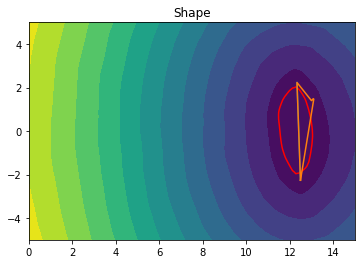

1


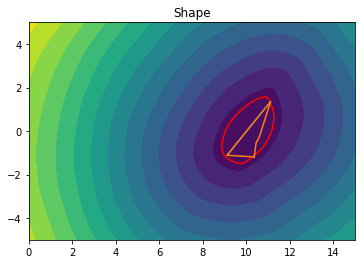

2


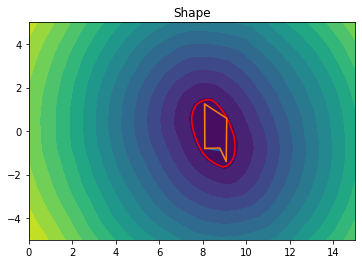

3


KeyboardInterrupt: 

In [29]:
for i, (train_batch, labels_batch) in enumerate(val_dl):
    print(i)
    scan_pts = train_batch[0][:-1,:].numpy()
    for ex in examples:
        if np.array_equal(ex[0], scan_pts):
            te = ex[6]
            break
    bounds = [0, 15, -5, 5]
    xs = np.linspace(*bounds[:2], 100)
    ys = np.linspace(*bounds[2:], 100)
    X, Y = np.meshgrid(xs, ys)
    pts = np.column_stack([
        X.ravel(),
        Y.ravel()
    ])

    dists = []
    for pt in pts:
        s = torch.Tensor(np.vstack([scan_pts, pt])).cuda()
        dists.append(model.forward(s).cpu().detach().numpy())

    fig, ax = plt.subplots()
    # # ax.scatter(X.ravel(), Y.ravel(), c=dists)
    ax.tricontourf(X.ravel(), Y.ravel(), dists, levels=14, cmap="viridis")
    ax.tricontour(X.ravel(), Y.ravel(), dists, levels=[0.4], colors='r')
    ax.plot(scan_pts[:,0], scan_pts[:,1])

    from data_generation.utils import plot_shape
    from data_generation.training_ex import glob_to_loc
    from shapely.geometry import Polygon

    coords = np.array(te.shape.exterior.coords)

    tf_shape = Polygon(glob_to_loc(coords, te.robang, te.robx, te.roby))
    # tf_shape = translate(rotate(te.shape, te.robang), te.robx, te.roby)
    plot_shape(tf_shape, ax, bounds=bounds, title="Reconstructed Shape")
    plt.pause(0.01)

In [49]:
for i, (train_batch, labels_batch) in enumerate(val_dl):
    scan_pts = train_batch[0][:-1,:].numpy()
    query_pt = train_batch[0][-1,:].numpy()
    print(query_pt)
    print(labels_batch[0])
    print(model.forward(train_batch[0].float().cuda()))
    break

[12.70627143  2.04551195]
tensor(2.6959, dtype=torch.float64)
tensor(0.6596, device='cuda:0', grad_fn=<SqueezeBackward0>)
